In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


# Import & EDA

In [2]:
df=pd.read_excel('DHHNGSP.xls')
df=df.set_index('Date')
df.head()

,Price
Date,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00


In [3]:
print(df.describe())
print('\n')
print(df.info())
print('Missing values: ', df.isna().sum())

             Price
count  6833.000000
mean      4.161444
std       2.184434
min       1.050000
25%       2.620000
50%       3.480000
75%       5.220000
max      23.860000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7096 entries, 1997-01-07 to 2024-03-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   6833 non-null   float64
dtypes: float64(1)
memory usage: 110.9 KB
None
Missing values:  Price    263
dtype: int64


In [4]:
df=df[~df['Price'].isna()]
df.shape

(6833, 1)

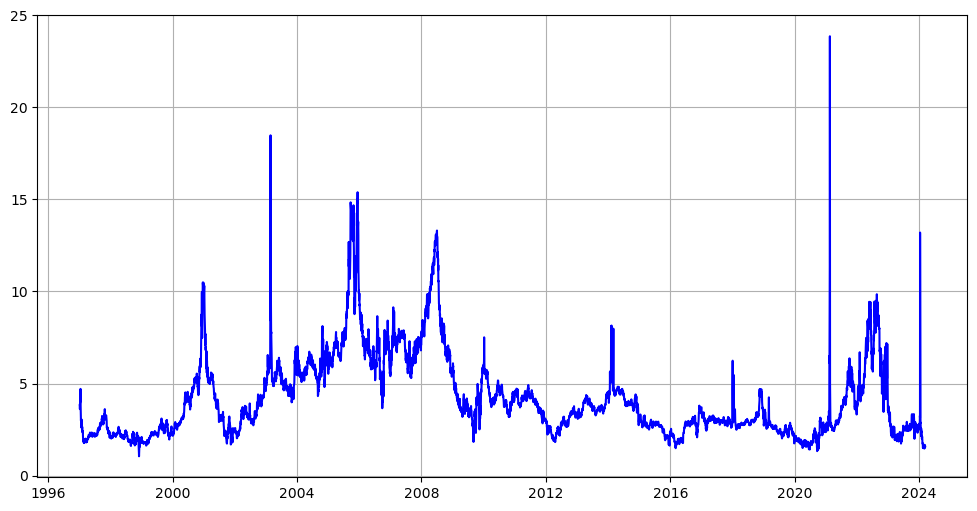

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='b')
plt.grid(True)
plt.show()

In [6]:
start_date = '2004-01-01'
end_date = '2024-02-01'

df = df[(df.index >= start_date) & (df.index < end_date)]
df.shape

(5056, 1)

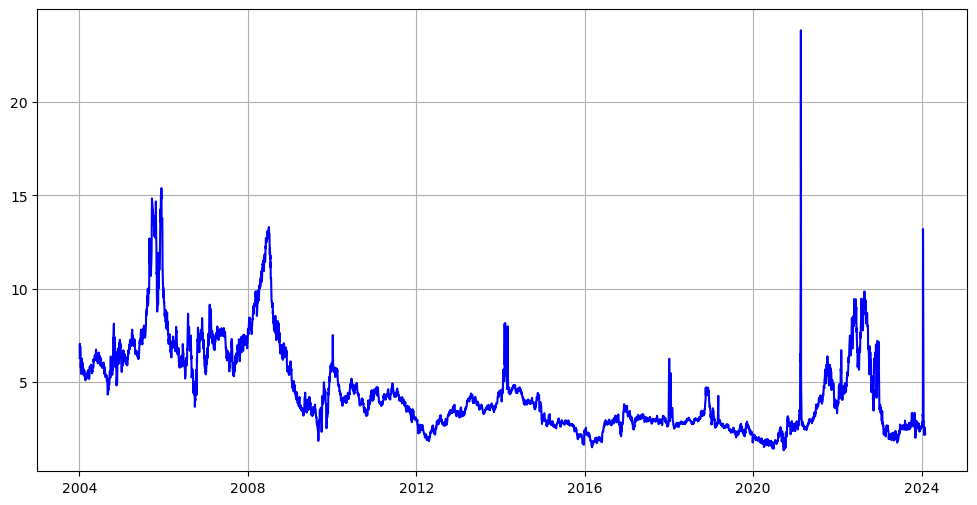

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='b')
plt.grid(True)
plt.show()

In [8]:
df=df.reset_index().resample('M', on='Date').mean()
df.shape

(241, 1)

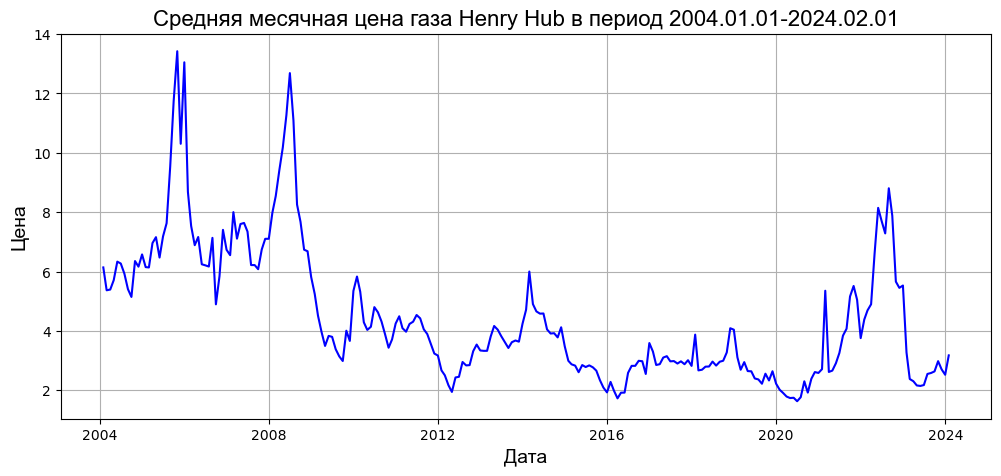

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], color='b')
plt.title('Средняя месячная цена газа Henry Hub в период 2004.01.01-2024.02.01', fontsize=16, fontname='Arial')
plt.xlabel('Дата', fontsize=14, fontname='Arial')
plt.ylabel('Цена', fontsize=14, fontname='Arial')
plt.grid(True)
plt.show()

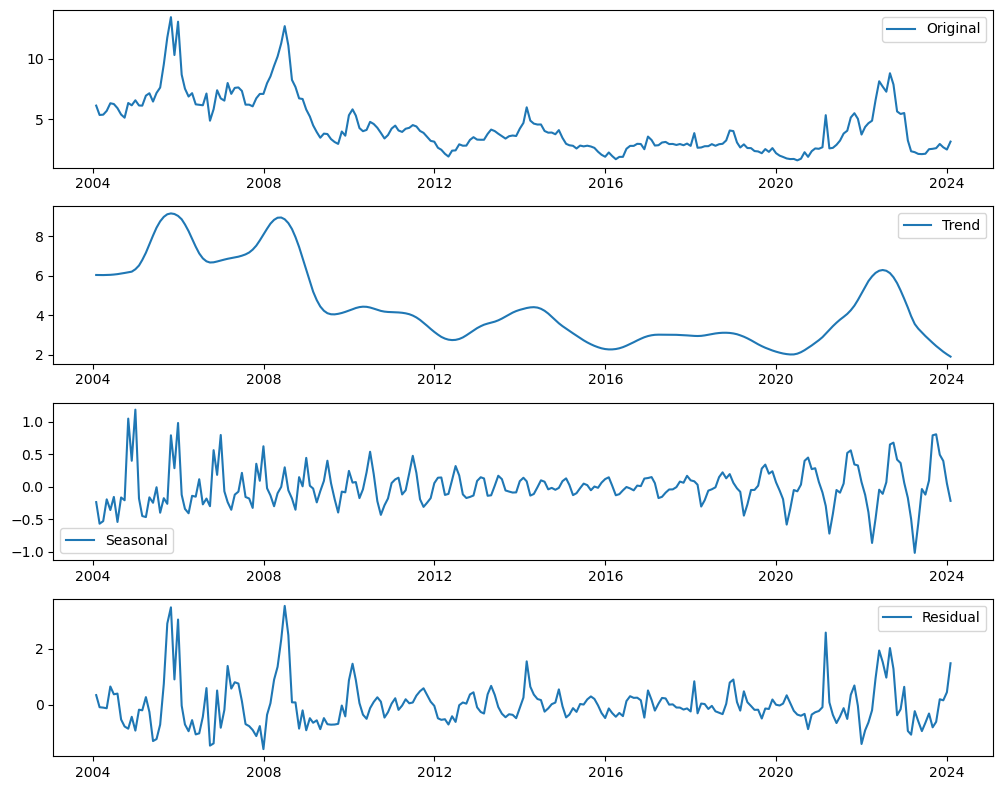

In [10]:
stl_result = STL(df['Price'], seasonal=13).fit()

# Plot the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(df['Price'], label='Original')
ax1.legend()

ax2.plot(stl_result.trend, label='Trend')
ax2.legend()

ax3.plot(stl_result.seasonal, label='Seasonal')
ax3.legend()

ax4.plot(stl_result.resid, label='Residual')
ax4.legend()

plt.tight_layout()
plt.show()

# SARIMA

In [11]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller


In [12]:
adfuller(df['Price'])[:2]

(-2.620080120604656, 0.08891772483153243)

In [13]:
adfuller(np.diff(df['Price'], n=12))[:2]

(-17.34710898788935, 5.2978717353900854e-30)

In [14]:
from itertools import product

ps, qs, Ps, Qs=range(5), range(5), range(5), range(5)
d, D, s=1, 0, 12

arima_orders=list(product(ps, qs, Ps, Qs))

In [15]:
import pandas as pd
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d:int, D:int, s:int)->pd.DataFrame:
    res=[]
    
    for order in tqdm_notebook(order_list):
        try:
            model=SARIMAX(endog, order=(order[0], d, order[1]), 
                          seasonal_order=(order[2], D, order[3], s),
                          simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic=model.aic
        res.append([order, aic])
        
    res_df=pd.DataFrame(res)
    res_df.columns=['(p,q,P,Q)', 'AIC']
    res_df=res_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return res_df

In [16]:
train, test=df['Price'][:-3], df['Price'][-3:]
train.shape, test.shape

((238,), (3,))

In [17]:
sarima_model=SARIMAX(train, order=(4,1,3), seasonal_order=(0,0,0,12)) # find on Mac
sarima_model_fit=sarima_model.fit(disp=False)

C:\Users\akim2\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


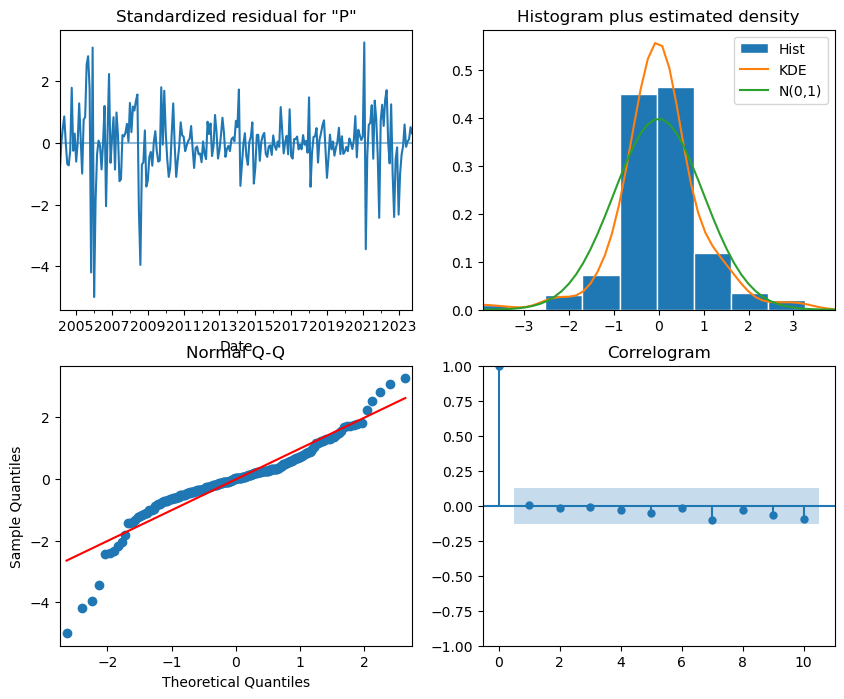

In [18]:
sarima_model_fit.plot_diagnostics(figsize=(10,8));

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resid=sarima_model_fit.resid
acorr_ljungbox(resid, np.arange(1,11))

,lb_stat,lb_pvalue
1,0.140116,0.708166
2,0.168469,0.919216
3,0.181053,0.980588
4,0.181053,0.996142
5,0.531157,0.990938
6,0.776763,0.992682
7,3.333158,0.852568
8,3.527141,0.897073
9,3.527218,0.939693
10,5.033889,0.888903


In [20]:
test

Date
2023-11-30    2.707619
2023-12-31    2.523000
2024-01-31    3.176190
Freq: M, Name: Price, dtype: float64

In [21]:
sarima_preds=sarima_model_fit.get_prediction(train.shape[0], train.shape[0]+test.shape[0]-1).predicted_mean
sarima_preds

2023-11-30    3.285618
2023-12-31    3.230168
2024-01-31    2.994158
Freq: M, Name: predicted_mean, dtype: float64

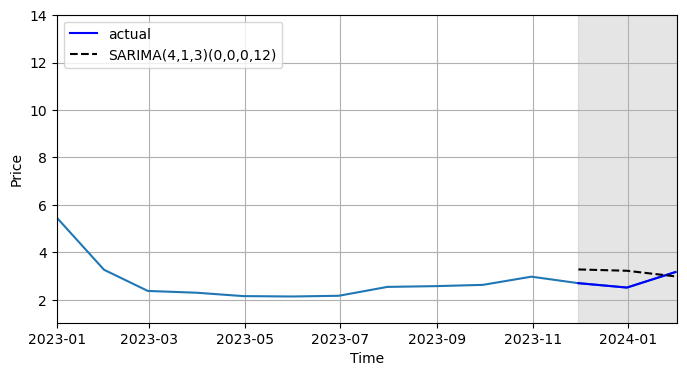

In [22]:
plt.figure(figsize=(8,4))

plt.plot(df['Price'])
plt.plot(test, 'b-', label='actual')
plt.plot(sarima_preds, 'k--', label='SARIMA(4,1,3)(0,0,0,12)')

plt.legend(loc=2)

plt.xlabel('Time')
plt.ylabel('Price')

plt.axvspan('2023-11-30', '2024-02-01', color='#808080', alpha=0.2)

plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-02-01'))

plt.grid();

In [23]:
import numpy as np

def calculate_metrics(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(actual - predicted))
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    metrics = {
        'MAE': mae.round(4),
        'RMSE': rmse.round(4),
        'MAPE': mape.round(4)
    }
    
    return metrics

In [24]:
metrics_result = calculate_metrics(test, sarima_preds)
print(metrics_result)

{'MAE': 0.4891, 'RMSE': 0.5377, 'MAPE': 18.369}


# LSTM

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler

seed_value = 123
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [30]:
scaler = MinMaxScaler()
input_size, output_size=3, 3

def prepare_lstm_dataset(series, input_size=input_size, output_size=output_size, sc=scaler):
    """
    Prepare dataset for LSTM modeling with a sliding window.

    Parameters:
    series (pd.Series): Time series data.
    input_size (int): Number of input time steps.
    output_size (int): Number of output time steps.

    Returns:
    tuple: Tuple containing input and output sequences.
    """
    # Normalize the series using MinMaxScaler
    normalized_series = sc.fit_transform(np.array(series).reshape(-1, 1)).flatten()
#     normalized_series=series

    # Initialize empty lists for input and output sequences
    X, y = [], []

    # Generate sliding window input and output sequences
    for i in range(len(normalized_series) - input_size - output_size + 1):
        input_seq = normalized_series[i:i + input_size]
        output_seq = normalized_series[i + input_size:i + input_size + output_size]

        X.append(input_seq)
        y.append(output_seq)

    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], input_size, 1))

    return X, y

# Example usage:
# Assuming df is your original dataframe with 'Price' as the column

# Prepare LSTM dataset with sliding window
X_lstm, y_lstm = prepare_lstm_dataset(df['Price'])
X_lstm_train, y_lstm_train=X_lstm[:-1], y_lstm[:-1] 
X_lstm_test, y_lstm_test = prepare_lstm_dataset(df['Price'].values[-(input_size + output_size):], input_size, output_size)

X_lstm_train.shape, y_lstm_train.shape, X_lstm_test.shape, y_lstm_test.shape

((235, 3, 1), (235, 3), (1, 3, 1), (1, 3))

In [31]:
X_lstm_train[:3], y_lstm_train[:3]

(array([[[0.38226673],
         [0.31696011],
         [0.31907754]],
 
        [[0.31696011],
         [0.31907754],
         [0.3458053 ]],
 
        [[0.31907754],
         [0.3458053 ],
         [0.39876748]]]),
 array([[0.3458053 , 0.39876748, 0.39342219],
        [0.39876748, 0.39342219, 0.36466627],
        [0.39342219, 0.36466627, 0.32013353]]))

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Assuming X_lstm and y_lstm are your prepared LSTM dataset
input_shape = (X_lstm_train.shape[1], X_lstm_train.shape[2])  # (time steps, features)
output_size = y_lstm_train.shape[1]  # Number of output time steps

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(16, input_shape=input_shape, return_sequences=True))  # Use return_sequences for stacked LSTM layers
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(16, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(16, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(16, return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(output_size, activation='linear'))  # Dense output layer with linear activation
lstm_model.compile(loss='mean_squared_error', optimizer='adam')  # Compile with mean squared error loss and Adam optimizer

# Early stopping with patience of 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0989 - val_loss: 0.0850
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0889 - val_loss: 0.0744
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0781 - val_loss: 0.0629
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0656 - val_loss: 0.0508
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0565 - val_loss: 0.0396
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0445 - val_loss: 0.0329
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0420 - val_loss: 0.0323
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0392 - val_loss: 0.0316
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0368 - val_loss: 0.0309
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0356 - val_loss: 0.0303
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0337 - val_loss: 0.0291
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0312 - val_loss: 0.0280
Epoch 13/50

In [33]:
# X_lstm_test_scaled = scaler.transform(X_lstm_test.reshape(-1, 1)).reshape(X_lstm_test.shape)
y_lstm_pred_scaled = lstm_model.predict(X_lstm_test)
y_lstm_pred_original = scaler.inverse_transform(y_lstm_pred_scaled.reshape(-1, 1)).flatten()
y_lstm_test=scaler.inverse_transform(y_lstm_test.reshape(-1, 1)).flatten()

metrics_lstm = calculate_metrics(y_lstm_test.flatten(), y_lstm_pred_original)
print("LSTM Metrics:", metrics_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
LSTM Metrics: {'MAE': 0.2454, 'RMSE': 0.325, 'MAPE': 8.1736}


In [34]:
print(y_lstm_pred_original)
y_lstm_test

[2.630043 2.635679 2.630217]


array([2.70761905, 2.523     , 3.17619048])

In [144]:
import joblib
from tensorflow.keras.models import save_model, load_model

# save_model(lstm_model, "lstm_model_univariate_gas.h5")
# joblib.dump(scaler, 'minmax_scaler_univariate_gas.joblib')

C:\Users\akim2\AppData\Local\Temp\ipykernel_9364\4019693951.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(lstm_model, "lstm_model_univariate_gas.h5")


['minmax_scaler_univariate_gas.joblib']

# Chap 3. Multivalriate LSTM+Outlier removal

## Gold df

In [35]:
# gold_df=pd.read_csv('Gold Futures Historical Data.csv')[['Date', 'Price']]
# gold_df['Date'] = pd.to_datetime(gold_df['Date'], format='%m/%d/%Y')
# gold_df.sort_values(by='Date', inplace=True)
# gold_df.reset_index(drop=True, inplace=True)
# gold_df=gold_df.set_index('Date')

# gold_df['Price']=pd.to_numeric(gold_df['Price'].str.replace(',', ''), errors='coerce')

# gold_df_small=pd.read_csv('Gold Futures Historical Data_small.csv')[['Date', 'Price']]
# gold_df_small['Date'] = pd.to_datetime(gold_df_small['Date'], format='%m/%d/%Y')
# gold_df_small.sort_values(by='Date', inplace=True)
# gold_df_small.reset_index(drop=True, inplace=True)
# gold_df_small=gold_df_small.set_index('Date')
# gold_df_small['Price']=pd.to_numeric(gold_df_small['Price'].str.replace(',', ''), errors='coerce')

# gold_df = pd.concat([gold_df, gold_df_small])
# gold_df=gold_df[~gold_df.index.duplicated(keep='first')]
# gold_df = gold_df[(gold_df.index >= start_date) & (gold_df.index <= end_date)]
# gold_df=gold_df.reset_index().resample('M', on='Date').mean()
# gold_df

In [36]:
import yfinance as yf

# Define the ticker symbol for gold
ticker_symbol = "GC=F"

# Download the data
gold_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the first few rows of the data
gold_data=gold_data['Close'].reset_index().resample('M', on='Date').mean()
gold_data.columns=['Close_Gold']
gold_data

[*********************100%%**********************]  1 of 1 completed


,Close_Gold
Date,
2004-01-31,414.726317
2004-02-29,403.952630
2004-03-31,407.469565
2004-04-30,403.957142
2004-05-31,383.769995
...,...
2023-09-30,1912.409998
2023-10-31,1915.568176
2023-11-30,1985.649997


## US Dollar index df

In [37]:
from scipy.stats import zscore as zs
from scipy import linalg as scipy_linalg

# us_df=pd.read_csv('US Dollar Index Futures Historical Data.csv')[['Date', 'Price']]
# us_df['Date'] = pd.to_datetime(us_df['Date'], format='%b %d, %Y')
# us_df.sort_values(by='Date', inplace=True)
# us_df.reset_index(drop=True, inplace=True)
# us_df=us_df.set_index('Date')

# us_df_small=pd.read_csv('US Dollar Index Futures Historical Data_small.csv')[['Date', 'Price']]
# us_df_small['Date'] = pd.to_datetime(us_df_small['Date'], format='%b %d, %Y')
# us_df_small.sort_values(by='Date', inplace=True)
# us_df_small.reset_index(drop=True, inplace=True)
# us_df_small=us_df_small.set_index('Date')

# us_df = pd.concat([us_df, us_df_small])
# us_df=us_df[~us_df.index.duplicated(keep='first')]
# us_df = us_df[(us_df.index >= start_date) & (us_df.index <= end_date)]
# us_df=us_df.reset_index().resample('M', on='Date').mean()
# us_df

In [38]:
import yfinance as yf

# Define the ticker symbol for US Dollar Index
ticker_symbol = "DX-Y.NYB"

# Download the data
usdx_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the first few rows of the data
usdx_data=usdx_data['Close'].reset_index().resample('M', on='Date').mean()
usdx_data.columns=['Close_USDX']
usdx_data

[*********************100%%**********************]  1 of 1 completed


,Close_USDX
Date,
2004-01-31,86.441428
2004-02-29,86.347499
2004-03-31,88.457826
2004-04-30,89.836191
2004-05-31,90.548999
...,...
2023-09-30,105.331499
2023-10-31,106.353182
2023-11-30,104.527143


## S&P500

In [39]:
import yfinance as yf

ticker_symbol = "^GSPC"

sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)

sp500_data=sp500_data['Close'].reset_index().resample('M', on='Date').mean()
sp500_data.columns=['Close_S&P']
sp500_data

[*********************100%%**********************]  1 of 1 completed


,Close_S&P
Date,
2004-01-31,1132.517499
2004-02-29,1143.356323
2004-03-31,1123.978245
2004-04-30,1133.078573
2004-05-31,1102.781500
...,...
2023-09-30,4409.094995
2023-10-31,4269.400945
2023-11-30,4460.063314


## Dow Jones

In [40]:
start_date, end_date

('2004-01-01', '2024-02-01')

In [41]:
import yfinance as yf

# Define the ticker symbol for Dow Jones Industrial Average
ticker_symbol = "^DJI"

# Download the data
dow_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the first few rows of the data
dow_data=dow_data['Close'].reset_index().resample('M', on='Date').mean()
dow_data

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2004-01-31,10540.046973
2004-02-29,10601.498972
2004-03-31,10323.728261
2004-04-30,10418.404250
2004-05-31,10083.805469
...,...
2023-09-30,34318.890820
2023-10-31,33319.492720
2023-11-30,34704.502418


## Dow Jones U.S. Oil & Gas Index

In [42]:
# https://www.investing.com/indices/dj-oil---gas-historical-data
dowog_df=pd.read_csv('Dow Jones Oil & Gas Historical Data.csv', delimiter='\t')
dowog_df['Date'] = pd.to_datetime(dowog_df['Date'])
dowog_df.sort_values(by='Date', inplace=True)
dowog_df['Date']= dowog_df['Date'] + pd.offsets.DateOffset(months=1) - pd.offsets.Day(1)  # Shift to end of the month
dowog_df=dowog_df.set_index('Date')[['Price']]
dowog_df.head()

C:\Users\akim2\AppData\Local\Temp\ipykernel_12548\2701782694.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dowog_df['Date'] = pd.to_datetime(dowog_df['Date'])


,Price
Date,
2004-01-31,249.49
2004-02-29,260.01
2004-03-31,258.45
2004-04-30,263.18
2004-05-31,262.26


## Non-US Oil and Gas Companies

In [43]:
# https://finance.yahoo.com/u/yahoo-finance/watchlists/oil-and-gas-stocks/
# https://companiesmarketcap.com/oil-gas/largest-oil-and-gas-companies-by-market-cap/
# from here filter out all US companies

top_30_df=pd.read_csv('top_30_comps.csv')
top_30_df=top_30_df.sort_values(by='marketcap', ascending=False)[:30]
top_30_df['marketcap']=top_30_df['marketcap']/1e9
top_30_df=top_30_df[top_30_df['country']!='United States'].reset_index(drop=True)

country_currency = {
    'Saudi Arabia': 'SAR',
    'China': 'CNY',
    'United Kingdom': 'GBP',
    'France': 'EUR',
    'United Arab Emirates': 'AED',
    'Brazil': 'BRL',
    'Canada': 'CAD',
    'Norway': 'NOK',
    'Russia': 'RUB',
    'Italy': 'EUR'
}

top_30_df['currency'] = top_30_df['country'].map(country_currency)

top_30_df

,Rank,Name,Symbol,marketcap,price (USD),country,currency
0,1,Saudi Aramco,2222.SR,1991.402287,8.23,Saudi Arabia,SAR
1,4,PetroChina,601857.SS,226.027384,1.29,China,CNY
2,5,Shell,SHEL,215.975592,66.92,United Kingdom,GBP
3,6,TotalEnergies,TTE,159.923978,67.84,France,EUR
4,8,CNOOC,0883.HK,121.118843,2.30,China,CNY
5,9,BP,BP,107.455193,37.80,United Kingdom,GBP
6,10,TAQA,TAQA.AE,100.743146,0.90,United Arab Emirates,AED
7,11,Sinopec,600028.SS,98.033295,0.86,China,CNY
8,12,Petrobras,PBR,94.933828,14.69,Brazil,BRL
9,13,Canadian Natural Resources,CNQ,79.770124,74.10,Canada,CAD


In [44]:
import numpy as np

def calculate_weights(df):
    df['Weight'] = np.sqrt(df['marketcap'])
    df['Weight'] = df['Weight'] / df['Weight'].sum()
    return df

In [45]:
top_30_df=calculate_weights(top_30_df)
top_30_df[['Name', 'Symbol', 'Weight']]

,Name,Symbol,Weight
0,Saudi Aramco,2222.SR,0.228638
1,PetroChina,601857.SS,0.077028
2,Shell,SHEL,0.075296
3,TotalEnergies,TTE,0.064793
4,CNOOC,0883.HK,0.056387
5,BP,BP,0.053111
6,TAQA,TAQA.AE,0.051425
7,Sinopec,600028.SS,0.050729
8,Petrobras,PBR,0.049921
9,Canadian Natural Resources,CNQ,0.045760


In [46]:
import yfinance as yf
import pandas as pd

def fetch_stock_prices(symbols, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date)
    stock_prices = pd.DataFrame(index=date_range)
    
    for symbol in symbols:
        data = yf.download(symbol, start=start_date, end=end_date)
        data.index = pd.to_datetime(data.index)  # Ensure index is datetime
        data = data['Close'].reindex(date_range)  # Reindex to fill missing dates
        stock_prices[symbol] = data
        
    return stock_prices

# Fetch stock prices for each company
stock_prices = fetch_stock_prices(top_30_df['Symbol'].to_list(), start_date, end_date)

stock_prices.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TAQA.AE']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Fa

,2222.SR,601857.SS,SHEL,TTE,0883.HK,BP,TAQA.AE,600028.SS,PBR,CNQ,EQNR,ENB,ADNOCGAS.AE,ROSN.ME,LKOH.ME,E
2004-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.807692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-02,NaN,NaN,52.750000,45.872688,NaN,49.400002,NaN,4.007692,7.55,6.49625,11.41,10.4825,NaN,NaN,NaN,38.751999
2004-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-05,NaN,NaN,53.529999,46.959858,NaN,49.900002,NaN,4.376923,8.10,6.89625,11.52,10.4475,NaN,NaN,NaN,39.408001


In [47]:
# ADNOC first date 03/14/2023, ignore
# Taga got from https://www.investing.com/equities/ad-natl-energy-historical-data

taga=pd.read_csv('TAQA Historical Data.csv')
# taga['Price']=taga['Price']*0.27
taga['Date'] = pd.to_datetime(taga['Date'], format='%m/%d/%Y')
taga.sort_values(by='Date', inplace=True)
taga.reset_index(drop=True, inplace=True)
taga=taga.set_index('Date')
taga=taga[(taga.index >= start_date) & (taga.index < end_date)]
date_range = pd.date_range(start=start_date, end=end_date)
taga_price = taga['Price'].reindex(date_range)

top_30_df=top_30_df[~top_30_df['Name'].isin(['ADNOC Gas'])]

stock_prices['TAQA.AE']=taga_price
stock_prices=stock_prices.drop('ADNOCGAS.AE', axis=1)
stock_prices.head()

,2222.SR,601857.SS,SHEL,TTE,0883.HK,BP,TAQA.AE,600028.SS,PBR,CNQ,EQNR,ENB,ROSN.ME,LKOH.ME,E
2004-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.807692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-02,NaN,NaN,52.750000,45.872688,NaN,49.400002,NaN,4.007692,7.55,6.49625,11.41,10.4825,NaN,NaN,38.751999
2004-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-05,NaN,NaN,53.529999,46.959858,NaN,49.900002,NaN,4.376923,8.10,6.89625,11.52,10.4475,NaN,NaN,39.408001


In [48]:
(stock_prices.isna().sum()/stock_prices.shape[0]).sort_values(ascending=False)

2222.SR      0.858798
ROSN.ME      0.585253
LKOH.ME      0.585253
601857.SS    0.461360
TAQA.AE      0.377130
0883.HK      0.329971
600028.SS    0.329562
SHEL         0.311163
TTE          0.311163
BP           0.311163
PBR          0.311163
CNQ          0.311163
EQNR         0.311163
ENB          0.311163
E            0.311163
dtype: float64

In [49]:
def fetch_currency_exchange_rates(currencies, start_date, end_date):
    exchange_rates = {}
    for currency in currencies:
        data = yf.download(f"{currency}=X", start=start_date, end=end_date)
        exchange_rates[currency] = data['Close']
        
    exchange_rates_df = pd.DataFrame(exchange_rates)
    return exchange_rates_df

currencies = top_30_df['currency'].unique()
exchange_rates_df = fetch_currency_exchange_rates(currencies, start_date, end_date)

stock_prices = pd.merge(stock_prices, exchange_rates_df, left_index=True, right_index=True)

currency_dict = dict(zip(top_30_df['Symbol'], top_30_df['currency']))

for symbol, currency in currency_dict.items():
    stock_prices[symbol] /= stock_prices[currency]

stock_prices.drop(columns=currencies, inplace=True)
stock_prices.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,2222.SR,601857.SS,SHEL,TTE,0883.HK,BP,TAQA.AE,600028.SS,PBR,CNQ,EQNR,ENB,ROSN.ME,LKOH.ME,E
2024-01-25,8.423277,1.128212,79.479552,70.633431,2.038972,44.706454,0.871460,0.831686,3.379625,47.636299,2.756745,26.387388,NaN,NaN,34.767186
2024-01-26,NaN,1.200378,80.278057,71.091540,2.059002,45.279521,0.865876,0.821906,3.468408,47.730698,2.796852,26.644012,NaN,NaN,35.079347
2024-01-29,8.342532,1.185336,80.515525,71.079260,2.074338,45.241575,0.863207,0.836791,3.492348,47.458005,2.786646,26.720679,NaN,NaN,35.035406
2024-01-30,8.356788,1.185687,81.225047,71.518344,2.046722,45.627906,0.857843,0.837039,3.442285,48.481139,2.828181,26.827922,NaN,NaN,35.157859
2024-01-31,8.170103,1.178444,79.867462,70.677280,2.038314,44.561243,0.857843,0.840135,3.448276,47.747674,2.746887,26.489176,NaN,NaN,34.644663


In [50]:
def calculate_weighted_average(stock_prices, top_30_df):
    weighted_avg_prices = pd.DataFrame(index=stock_prices.index)
    
    for idx, row in top_30_df.iterrows():
        symbol = row['Symbol']
        weight = row['Weight']
        
        weighted_avg_prices[symbol] = stock_prices[symbol] * weight
        
    weighted_avg_prices['Index'] = weighted_avg_prices.mean(axis=1)
    
    return weighted_avg_prices

weighted_avg_prices = calculate_weighted_average(stock_prices, top_30_df)
weighted_avg_prices.index.name = 'Date'
weighted_avg_prices.index = pd.to_datetime(weighted_avg_prices.index)
weighted_avg_prices.head()

non_us_ind=weighted_avg_prices['Index'].reset_index().resample('M', on='Date').mean()
non_us_ind.head()

,Index
Date,
2004-01-31,1.881460
2004-02-29,1.875449
2004-03-31,1.867499
2004-04-30,1.816742
2004-05-31,1.794646


## Final df

In [51]:
# merged_df = pd.merge(gold_df, us_df, left_index=True, right_index=True)
merged_df = pd.merge(gold_data, usdx_data, on='Date').merge(sp500_data, on='Date').merge(dowog_df, on='Date')\
    .merge(non_us_ind, on='Date')

final_df=pd.merge(df, merged_df, left_index=True, right_index=True)
final_df.columns=['GAS', 'GOLD', 'USD', 'S&P', 'DOWJONES_OG', 'NON_US_IND']
final_df.head()

,GAS,GOLD,USD,S&P,DOWJONES_OG,NON_US_IND
Date,,,,,,
2004-01-31,6.138947,414.726317,86.441428,1132.517499,249.49,1.881460
2004-02-29,5.368947,403.952630,86.347499,1143.356323,260.01,1.875449
2004-03-31,5.393913,407.469565,88.457826,1123.978245,258.45,1.867499
2004-04-30,5.709048,403.957142,89.836191,1133.078573,263.18,1.816742
2004-05-31,6.333500,383.769995,90.548999,1102.781500,262.26,1.794646


## Outliers

In [54]:
zscore = np.abs(zs(final_df['GAS']))
zscore_df = final_df.copy()
zscore_df['zscore'] = zscore

In [55]:
len(zscore_df[zscore_df['zscore']>=2.0])

10

## Correlation test

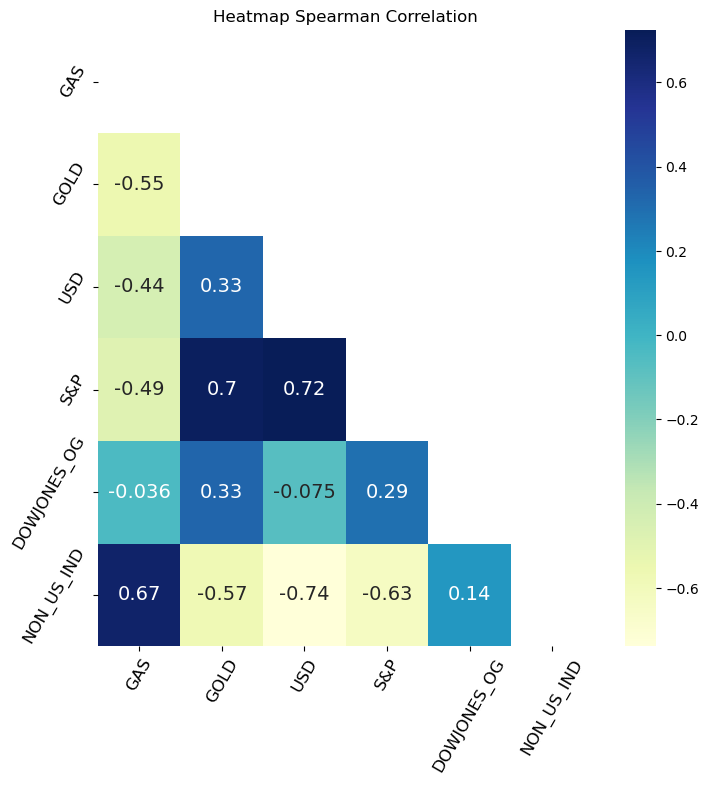

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
matrix = np.triu(final_df.corr(method='spearman'))
heat_map = sns.heatmap(final_df.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

## Final modelling

In [57]:
zscore_df = zscore_df.loc[zscore_df['zscore']<2.0, :]
zscore_df.shape

(231, 7)

In [65]:
scaler_2 = MinMaxScaler()
input_size, output_size=3, 3

def prepare_lstm_dataframe(series, input_size=input_size, output_size=output_size, sc=scaler_2):
    """
    Prepare dataset for LSTM modeling with a sliding window.

    Parameters:
    series (pd.DataFrame): Time series data with multiple columns.
    input_size (int): Number of input time steps.
    output_size (int): Number of output time steps.

    Returns:
    tuple: Tuple containing input and output sequences.
    """
    normalized_series = sc.fit_transform(series.values)
#     normalized_series=series.values

    # Initialize empty lists for input and output sequences
    X, y = [], []

    # Generate sliding window input and output sequences
    for i in range(len(normalized_series) - input_size - output_size + 1):
        input_seq = normalized_series[i:i + input_size, :]  # Include all columns
        output_seq = normalized_series[i + input_size:i + input_size + output_size, 0]  # Only the first column

        X.append(input_seq)
        y.append(output_seq)

    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], input_size, series.shape[1]))  # Keep all columns in features

    return X, y

In [66]:
selected_cols= ['GAS'
                ,'GOLD'
                ,'USD'
#                 , 'S&P'
#                 , 'DOWJONES_OG'
#                 ,'NON_US_IND'
               ]

X_final, y_final=prepare_lstm_dataframe(zscore_df[selected_cols])
X_final_train, y_final_train=X_final[:-1], y_final[:-1] 
X_final_test, y_final_test = prepare_lstm_dataframe(zscore_df[selected_cols].iloc[-(input_size + output_size):], input_size, output_size)

In [67]:
X_final[0], y_final[0]

(array([[0.62827342, 0.01878526, 0.32369545],
        [0.5209389 , 0.01224745, 0.32120427],
        [0.524419  , 0.01438164, 0.37717383]]),
 array([0.56834734, 0.65539317, 0.64660794]))

In [68]:
(X_final_train.shape[1], X_final_train.shape[2])

(3, 3)

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Assuming X_final_train and y_final_train are your new prepared LSTM dataset
input_shape = (X_final_train.shape[1], X_final_train.shape[2])  # (time steps, features)
output_size = y_final_train.shape[1]  # Number of output time steps

# Build the LSTM model
lstm_model_new = Sequential()
lstm_model_new.add(LSTM(64, input_shape=input_shape, return_sequences=True))  
lstm_model_new.add(Dropout(0.2))

lstm_model_new.add(LSTM(64, return_sequences=True))
lstm_model_new.add(Dropout(0.2))

lstm_model_new.add(LSTM(32, return_sequences=True))
lstm_model_new.add(Dropout(0.2))

lstm_model_new.add(LSTM(32, return_sequences=False))
lstm_model_new.add(Dropout(0.2))

lstm_model_new.add(Dense(output_size, activation='linear'))  
lstm_model_new.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=5e-4))  

# Early stopping with patience of 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
lstm_model_new.fit(X_final_train, y_final_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/50


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.1772 - val_loss: 0.2466
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1651 - val_loss: 0.2291
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1514 - val_loss: 0.2065
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1341 - val_loss: 0.1758
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1111 - val_loss: 0.1353
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0841 - val_loss: 0.0959
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0632 - val_loss: 0.0887
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0604 - val_loss: 0.0839
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0503 - val_loss: 0.0832
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0459 - val_loss: 0.0813
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0403 - val_loss: 0.0763
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0328 - val_loss: 0.0737
Epoch 13/50

In [70]:
y_final_test

array([[0.28264198, 0.        , 1.        ]])

In [71]:
y_final_pred_scaled = lstm_model_new.predict(X_final_test)
y_final_pred_original = scaler.inverse_transform(y_final_pred_scaled.reshape(-1, 1)).flatten()
if y_final_test.flatten()[0]<1:
    y_final_test=scaler.inverse_transform(y_final_test.reshape(-1, 1)).flatten()

metrics_lstm = calculate_metrics(y_final_test.flatten(), y_final_pred_original)
print("LSTM Metrics:", metrics_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
LSTM Metrics: {'MAE': 0.2243, 'RMSE': 0.2828, 'MAPE': 7.6705}


In [72]:
print(y_lstm_pred_original)
print(y_final_pred_original)
y_final_test

[2.630043 2.635679 2.630217]
[2.7287416 2.7325926 2.7339346]


array([2.70761905, 2.523     , 3.17619048])

In [73]:
# [80.35133 80.17848 81.8968 ]
# [78.833626 78.395836 79.11392 ]
# array([78.69628739, 73.40960915, 75.16614365])

In [74]:
from tensorflow.keras.models import save_model, load_model


# save_model(lstm_model, "lstm_model_univariate_oil.h5")
# save_model(lstm_model_new, "lstm_model_multivariate_oil.h5")

In [75]:
import joblib

# joblib.dump(scaler, 'minmax_scaler_univariate_oil.joblib')
# joblib.dump(scaler_2, 'minmax_scaler_multivariate_oil.joblib')

# Experimenting with many runs

## Multivariate LSTM

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


input_size, output_size=3, 3


selected_cols= ['GAS'
                ,'GOLD'
                ,'USD'
#                 , 'S&P'
#                 , 'DOWJONES_OG'
#                 ,'NON_US_IND'
               ]

zscore_reduced=zscore_df[selected_cols]

X_final, y_final=prepare_lstm_dataframe(zscore_reduced)
X_final_train, y_final_train=X_final[:-1], y_final[:-1] 
X_final_test, y_final_test = prepare_lstm_dataframe(zscore_reduced.iloc[-(input_size + output_size):], input_size, output_size)

In [77]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm_notebook
import keras.backend as K


# Assuming X_final_train and y_final_train are your new prepared LSTM dataset
input_shape = (X_final_train.shape[1], X_final_train.shape[2])  # (time steps, features)
output_size = y_final_train.shape[1]  # Number of output time steps


def build_lstm_multivar_model(input_shape=input_shape, output_size=output_size):
    lstm_model_new = Sequential()
    lstm_model_new.add(LSTM(64, input_shape=input_shape, return_sequences=True))  
    lstm_model_new.add(Dropout(0.2))

    lstm_model_new.add(LSTM(64, return_sequences=True))
    lstm_model_new.add(Dropout(0.2))
    
    lstm_model_new.add(LSTM(32, return_sequences=True))
    lstm_model_new.add(Dropout(0.2))

    lstm_model_new.add(LSTM(32, return_sequences=False))
    lstm_model_new.add(Dropout(0.2))
    
    lstm_model_new.add(Dense(output_size, activation='linear')) 
    return lstm_model_new


def train_and_evaluate(model_builder, X_train, y_train, X_test, y_test, num_runs=5, scaler=scaler, lr=5e-4):
    results = {'MAE': [],
              'RMSE': [],
              'MAPE': []}

    for i in tqdm_notebook(range(num_runs)):
        model = model_builder()
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.1, callbacks=[early_stopping])
        y_pred = model.predict(X_test)
        
        if y_test.flatten()[0]<1:
            y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
        mae, rmse, mape=list(calculate_metrics(y_test.flatten(), y_pred).values())
        results['MAE'].append(mae)
        results['RMSE'].append(rmse)
        results['MAPE'].append(mape)
        
        print(mae, rmse, mape)
        
        K.clear_session()


    results_df = pd.DataFrame(results)
    avg_metrics = results_df.mean(axis=0)
    avg_metrics.name = 'Average'
    results_df = pd.concat([results_df, avg_metrics.to_frame().T])
    results_df.index = list(range(1, num_runs + 1)) + ['Average']

    return results_df


In [82]:
import warnings

warnings.filterwarnings("ignore")

In [78]:
multivar_lstm_ress=train_and_evaluate(build_lstm_multivar_model, 
                   X_final_train, 
                   y_final_train,
                   X_final_test,
                   y_final_test,
                  35)

multivar_lstm_ress

C:\Users\akim2\AppData\Local\Temp\ipykernel_12548\3816072076.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(num_runs)):


  0%|          | 0/35 [00:00<?, ?it/s]

C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
0.2191 0.2897 7.419



C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
0.2218 0.2882 7.5335


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
0.2217 0.2946 7.4959


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
0.2242 0.2818 7.6565


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
0.2209 0.2909 7.4745


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
0.2225 0.2865 7.5682


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
0.2184 0.2839 7.4086


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
0.2213 0.2944 7.4842


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
0.2254 0.297 7.6036


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
0.2216 0.2948 7.4955


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
0.2235 0.2885 7.5885


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
0.222 0.2911 7.5294


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
0.2187 0.2905 7.3907


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
0.2188 0.2912 7.3883


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
0.2172 0.2913 7.3256


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
0.2232 0.2904 7.575


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
0.2231 0.2863 7.5998


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
0.2204 0.2927 7.4523


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
0.2225 0.2924 7.5392


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
0.2193 0.2907 7.4123


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
0.2191 0.287 7.4374


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
0.2209 0.2876 7.5014


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
0.2235 0.2834 7.6339


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
0.2235 0.2882 7.6005


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
0.2267 0.2879 7.726


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
0.2209 0.2976 7.4311


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
0.2233 0.2825 7.6159


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
0.2209 0.2873 7.5004


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
0.2233 0.2901 7.5773


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
0.2204 0.2924 7.4556


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
0.2183 0.2926 7.3651


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
0.2184 0.2913 7.376


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
0.2206 0.2881 7.4733


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
0.2223 0.2867 7.5529


C:\Users\akim2\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
0.2225 0.2896 7.5547


,MAE,RMSE,MAPE
1,0.219100,0.289700,7.419000
2,0.221800,0.288200,7.533500
3,0.221700,0.294600,7.495900
4,0.224200,0.281800,7.656500
5,0.220900,0.290900,7.474500
6,0.222500,0.286500,7.568200
7,0.218400,0.283900,7.408600
8,0.221300,0.294400,7.484200
9,0.225400,0.297000,7.603600
10,0.221600,0.294800,7.495500


## Univariate LSTM

In [85]:
input_size, output_size=3, 3

X_lstm, y_lstm = prepare_lstm_dataset(df['Price'])
X_lstm_train, y_lstm_train=X_lstm[:-1], y_lstm[:-1] 
X_lstm_test, y_lstm_test = prepare_lstm_dataset(df['Price'].values[-(input_size + output_size):], input_size, output_size)

In [86]:
input_shape = (X_lstm_train.shape[1], X_lstm_train.shape[2])  # (time steps, features)
output_size = y_lstm_train.shape[1]  # Number of output time steps


def build_lstm_univar_model(input_shape=input_shape, output_size=output_size):
    lstm_model = Sequential()
    lstm_model.add(LSTM(16, input_shape=input_shape, return_sequences=True)) 
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(16, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(16, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(16, return_sequences=False))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(output_size, activation='linear'))  
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')  
    return lstm_model

In [87]:
univar_lstm_ress=train_and_evaluate(build_lstm_univar_model, 
                   X_lstm_train, 
                   y_lstm_train,
                   X_lstm_test,
                   y_lstm_test,
                  35)

univar_lstm_ress

  0%|          | 0/35 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
0.2404 0.3219 8.004
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
0.2356 0.313 7.862
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
0.2402 0.3185 8.0092
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
0.2407 0.322 8.0114
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
0.239 0.3187 7.9588
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
0.2415 0.3225 8.043
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
0.2404 0.323 7.9858
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
0.2411 0.3198 8.0414
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
0.2364 0.3166 7.8754
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
0.2388 0.3203 7.9399
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
0.2376 0.3159 7.9196
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
0.2404 0.3189 8.0211
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
0.2407 0.3216 8.0032
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
0.2362 0.3133 7.8897
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
0.2352 0.3157 7.8265
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
0.2349 0.3197 7.7882
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
0.2378 0

,MAE,RMSE,MAPE
1,0.240400,0.321900,8.004000
2,0.235600,0.313000,7.862000
3,0.240200,0.318500,8.009200
4,0.240700,0.322000,8.011400
5,0.239000,0.318700,7.958800
6,0.241500,0.322500,8.043000
7,0.240400,0.323000,7.985800
8,0.241100,0.319800,8.041400
9,0.236400,0.316600,7.875400
10,0.238800,0.320300,7.939900


In [90]:
# with pd.ExcelWriter('model_exp.xlsx', mode='a') as writer:
#     univar_lstm_ress.to_excel(writer, sheet_name='univar_oil')
#     multivar_lstm_ress.to_excel(writer, sheet_name='multivar_oil')

## Stat tests

In [106]:
from scipy.stats import shapiro

# Model 1 metrics
mae_model1 = [0.2404, 0.2356, 0.2402, 0.2407, 0.239, 0.2415, 0.2404, 0.2411, 0.2364, 0.2388,
              0.2376, 0.2404, 0.2407, 0.2362, 0.2352, 0.2349, 0.2378, 0.2406, 0.2367, 0.2367,
              0.2368, 0.2378, 0.2467, 0.2368, 0.2424, 0.2422, 0.2397, 0.2391, 0.241, 0.2381,
              0.2399, 0.2344, 0.2449, 0.2371, 0.2411]

rmse_model1 = [0.3219, 0.313, 0.3185, 0.322, 0.3187, 0.3225, 0.323, 0.3198, 0.3166, 0.3203,
               0.3159, 0.3189, 0.3216, 0.3133, 0.3157, 0.3197, 0.3157, 0.3207, 0.3137, 0.3159,
               0.3133, 0.3146, 0.3233, 0.314, 0.3185, 0.3213, 0.3183, 0.3183, 0.3181, 0.3195,
               0.3195, 0.3146, 0.325, 0.3144, 0.3205]

mape_model1 = [8.004, 7.862, 8.0092, 8.0114, 7.9588, 8.043, 7.9858, 8.0414, 7.8754, 7.9399,
               7.9196, 8.0211, 8.0032, 7.8897, 7.8265, 7.7882, 7.9327, 8.0151, 7.8996, 7.8984,
               7.9031, 7.938, 8.2402, 7.91, 8.0909, 8.0854, 8.0038, 7.97, 8.0393, 7.9194,
               7.9875, 7.8019, 8.1581, 7.907, 8.0413]

# Model 2 metrics
mae_model2 = [0.2191, 0.2218, 0.2217, 0.2242, 0.2209, 0.2225, 0.2184, 0.2213, 0.2254, 0.2216,
              0.2235, 0.222, 0.2187, 0.2188, 0.2172, 0.2232, 0.2231, 0.2204, 0.2225, 0.2193,
              0.2191, 0.2209, 0.2235, 0.2235, 0.2267, 0.2209, 0.2233, 0.2209, 0.2233, 0.2204,
              0.2183, 0.2184, 0.2206, 0.2223, 0.2225]

rmse_model2 = [0.2897, 0.2882, 0.2946, 0.2818, 0.2909, 0.2865, 0.2839, 0.2944, 0.297, 0.2948,
               0.2885, 0.2911, 0.2905, 0.2912, 0.2913, 0.2904, 0.2863, 0.2927, 0.2924, 0.2907,
               0.287, 0.2876, 0.2834, 0.2882, 0.2879, 0.2976, 0.2825, 0.2873, 0.2901, 0.2924,
               0.2926, 0.2913, 0.2881, 0.2867, 0.2896]

mape_model2 = [7.419, 7.5335, 7.4959, 7.6565, 7.4745, 7.5682, 7.4086, 7.4842, 7.6036, 7.4955,
               7.5885, 7.5294, 7.3907, 7.3883, 7.3256, 7.575, 7.5998, 7.4523, 7.5392, 7.4123,
               7.4374, 7.5014, 7.6339, 7.6005, 7.726, 7.4311, 7.6159, 7.5004, 7.5773, 7.4556,
               7.3651, 7.376, 7.4733, 7.5529, 7.5547]

# Perform Shapiro-Wilk normality test for each metric
print("Shapiro-Wilk Normality Test Results:")
print("Model 1:")
print("MAE:", shapiro(mae_model1))
print("RMSE:", shapiro(rmse_model1))
print("MAPE:", shapiro(mape_model1))

print("\nModel 2:")
print("MAE:", shapiro(mae_model2))
print("RMSE:", shapiro(rmse_model2))
print("MAPE:", shapiro(mape_model2))


Shapiro-Wilk Normality Test Results:
Model 1:
MAE: ShapiroResult(statistic=0.9608147740364075, pvalue=0.24186982214450836)
RMSE: ShapiroResult(statistic=0.9607996344566345, pvalue=0.24161803722381592)
MAPE: ShapiroResult(statistic=0.9704521894454956, pvalue=0.45579293370246887)

Model 2:
MAE: ShapiroResult(statistic=0.9762042164802551, pvalue=0.6334096789360046)
RMSE: ShapiroResult(statistic=0.9820603132247925, pvalue=0.8239656686782837)
MAPE: ShapiroResult(statistic=0.9867885112762451, pvalue=0.9416983127593994)


In [96]:
# Model 1 data
model1_data = {
    'MAE': mae_model1,
    'RMSE': rmse_model1,
    'MAPE': mape_model1
}

model1_df = pd.DataFrame(model1_data)

# Model 2 data
model2_data = {
    'MAE': mae_model2,
    'RMSE': rmse_model2,
    'MAPE': mape_model2
}

model2_df = pd.DataFrame(model2_data)

In [108]:
from scipy.stats import levene

# Levene's test for equality of variances
def check_homogeneity(data1, data2, metric_name):
    metrics = list(data1.keys())
    for metric in metrics:
        stat, p = levene(data1[metric], data2[metric])
        print(f"{metric_name}: {metric} - p-value: {p}")

# Check assumptions for Model 1 and Model 2
print("Homogeneity of Variance Test:")
check_homogeneity(model1_data, model2_data, "Models Comparison")


Homogeneity of Variance Test:
Models Comparison: MAE - p-value: 0.1721010933507767
Models Comparison: RMSE - p-value: 0.6336082362208559
Models Comparison: MAPE - p-value: 0.8960634635100789


In [101]:
from scipy import stats

# Define the data for model 1 and model 2
# Assuming you have already defined the data for each metric

# Perform the Mann-Whitney U test for each metric
print("Mann-Whitney U Test Results:")
print("Model 1 vs. Model 2")

# MAE
statistic, p_value = stats.mannwhitneyu(mae_model1, mae_model2)
print("MAE - Statistic:", statistic, "p-value:", p_value)

# RMSE
statistic, p_value = stats.mannwhitneyu(rmse_model1, rmse_model2)
print("RMSE - Statistic:", statistic, "p-value:", p_value)

# MAPE
statistic, p_value = stats.mannwhitneyu(mape_model1, mape_model2)
print("MAPE - Statistic:", statistic, "p-value:", p_value)


Mann-Whitney U Test Results:
Model 1 vs. Model 2
MAE - Statistic: 1225.0 p-value: 6.452672923679785e-13
RMSE - Statistic: 1225.0 p-value: 6.515422124175221e-13
MAPE - Statistic: 1225.0 p-value: 6.545500588914153e-13


In [100]:
# cannot use, metrics are not gaussian

from scipy import stats

for m in ['MAE', 'RMSE', "MAPE"]:
    metrics_model_uni = model1_df[m].to_list()
    metrics_model_multi = model2_df[m].to_list()

    # Perform independent samples t-test
    t_statistic, p_value = stats.ttest_ind(metrics_model_uni, metrics_model_multi)

    # Print the results
    print(m)
    print(f'\tUnivariate: mean={np.mean(metrics_model_uni).round(4)}, std={np.std(metrics_model_uni).round(4)}')
    print(f'\tMultivariate: mean={np.mean(metrics_model_multi).round(4)}, std={np.std(metrics_model_multi).round(4)}')
    print("\tt-statistic:", round(t_statistic, 4))
    print("\tp-value:", p_value, end='\n\n')


MAE
	Univariate: mean=0.2391, std=0.0027
	Multivariate: mean=0.2214, std=0.0021
	t-statistic: 29.715
	p-value: 1.114833858091161e-40

RMSE
	Univariate: mean=0.3183, std=0.0032
	Multivariate: mean=0.2897, std=0.0037
	t-statistic: 33.9095
	p-value: 2.462072925644777e-44

MAPE
	Univariate: mean=7.9692, std=0.0938
	Multivariate: mean=7.5069, std=0.0918
	t-statistic: 20.5327
	p-value: 7.3541985065874175e-31



In [95]:
for i in (mae_model1, rmse_model1, mape_model1, mae_model2, rmse_model2, mape_model2):
    print(np.mean(i).round(3), np.std(i).round(3))

0.239 0.003
0.318 0.003
7.969 0.094
0.221 0.002
0.29 0.004
7.507 0.092


## Multivar Bayesian Search